<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Change Detection Behavior + Optical Physiology </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 21, 2018</h3> 

<img src="../resources/change_detection_schematic.png" height="400" width="400">  


This notebook will introduce you to the Visual Behavior pilot dataset. This pre-release dataset uses 2-photon calcium imaging (also called optical physiology or ophys) to measure neural activity in behaving mice, and was collected during piloting for the new Visual Behavior Brain Observatory. Production data collection for the Observatory will begin September 2018 and data will be publicly released in 2019. The insights obtained here at SWDB may help shape the collection of the production dataset. 

The change detection task consists of a series of image presentations. Each image flash is 250ms followed by 500ms of gray screen. The task for the mouse is to lick in a 750ms response window following a change in image identity. On each trial, a change time is scheduled. On go trials, a change in image identity occurs. On catch trials, no image change occurs (aka 'sham change'), and we measure false alarm rates in the same 750ms response window. Correct responses are rewarded and licks outside the response window result in a timeout.

There are 8 natural scene images shown in each behavioral session, with 4 unique sets of 8 that can shown in different sessions. One of these image sets has been seen by the mouse many times during initial behavioral training, while the other 3 image sets are seen for the first time under the microscope. 

In this notebook, we will describe the dimensions of the dataset, the core components of each experimental session, and the tools for accessing and analyzing the data. 

You will be working with a single experimental session recorded in a specific cre line and visual area. Other students will have sessions with different areas, cre lines and stimulus sets. As you work through the exercises, compare results with your neighbors to see what the similarities and differences are.

At the end of the notebook, you will compute a value for a metric called lifetime sparseness that measures each neuron's selectivity for stimulus identity, and take the mean across the population of neurons in your experiment session. We will collect the mean sparseness value from each student's unique experiment session to collectively make a plot that compares how sparseness varies across excitatory and inhibitory cell populations, and for stimulus sets that are novel or familiar to the mouse. 

** Outline:**
1.	Explore the dataset using the manifest file
2.	VisualBehaviorOphysDataset class – accessing data and metadata
3.	Optical physiology data – calcium traces and rois
4.	Change detection behavior data – running speed, licks, rewards, and visual stimuli
5.	Trials dataframe – structure for organizing behavior data by trials
6.	ResponseAnalysis class – structures for analyzing cell responses by trials and stimulus flashes
7.	Lifetime sparseness – computing a selectivity metric for responsive cells
8.	Project ideas


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>Let's get started

</div>

In [1]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');

# Import allensdk modules for loading and interacting with the data
from allensdk.internal.api import behavior_ophys_api as boa #TODO: We probably won't use this, but instead use the NWB api
from allensdk.brain_observatory.behavior import behavior_ophys_session as bos

import SimpleITK as sitk

from importlib import reload
reload(boa)
reload(bos)

<module 'allensdk.brain_observatory.behavior.behavior_ophys_session' from '/allen/programs/braintv/workgroups/nc-ophys/nick.ponvert/src/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_session.py'>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The dimensions of the dataset are described in the manifest file. You can inspect the manifest to identify experiments of interest and their metadata. 

<p>The manifest file is located in the cache directory, along with the data itself. 

<p>Make sure your `drive_path` is set properly, and complete the following task to load and inspect the `manifest_file`. </div>



In [5]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2018/visual_behavior/'

# Windows (a good guess)
drive_path = r'/'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2018/visual_behavior'



# AWS
#drive_path = '/data/dynamic-brain-workshop/visual_behavior'
#TODO: Find out where the data will be stored for 2019

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.1:**  Get information about what's in the dataset 

<p>Read in 'visual_behavior_data_manifest.csv' using pandas and explore the columns to see the available visual areas, cre lines, and session types. 

</div>

In [2]:
manifest_file = 'visual_behavior_data_manifest.csv'

In [3]:
#manifest = pd.read_csv(os.path.join(drive_path,manifest_file))

manifest=pd.read_csv(manifest_file, index_col=0)
manifest = manifest.reset_index(drop=True)

In [4]:
manifest.head(50)

,container_id,container_workflow_state,donor_id,full_genotype,sex,created_at,behavior_session_id,equipment_name,ophys_session_name,ophys_experiment_id,ophys_workflow_state,imaging_depth,targeted_structure,stage_name,retake_number
0,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-08 20:45:52.011892,775378326,CAM2P.5,20181108_403491_1imagesA,775614751,passed,375,VISp,OPHYS_1_images_A,0.0
1,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-13 19:45:53.130447,778166125,CAM2P.5,20181113_403491_2imagesA,778644591,passed,375,VISp,OPHYS_2_images_A_passive,0.0
2,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-12-10 18:40:53.679184,792499741,CAM2P.5,20181210_403491_4imagesB,792812544,passed,375,VISp,OPHYS_4_images_B,2.0
3,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-12-15 19:10:57.996849,796032489,CAM2P.5,20181215_403491_5imagesB,796106850,passed,375,VISp,OPHYS_5_images_B_passive,2.0
4,782536745,postprocessing,722884873,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,F,2018-11-29 18:55:48.200392,788017709,CAM2P.5,20181129_403491_6imagesB,788490510,passed,375,VISp,OPHYS_6_images_B,0.0
5,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-10 22:55:54.442359,792680306,CAM2P.4,20181210_412036_1imagesA,792815735,passed,175,VISp,OPHYS_1_images_A,0.0
6,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-19 01:00:55.101414,798126878,CAM2P.4,20181218_412036_2_images_passive,798404219,passed,175,VISp,OPHYS_2_images_A_passive,1.0
7,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-13 22:50:55.961023,794968300,CAM2P.4,20181213_412036_3imagesA,795073741,passed,175,VISp,OPHYS_3_images_A,0.0
8,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-14 21:55:54.143808,795742990,CAM2P.4,20181214_412036_4imagesB,795953296,passed,175,VISp,OPHYS_4_images_B,0.0
9,791352433,container_qc,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,F,2018-12-15 22:25:51.747219,796052844,CAM2P.4,20181215_412036_5imagesB,796108483,passed,175,VISp,OPHYS_5_images_B_passive,0.0


In [5]:
print('targeted structures:', manifest.targeted_structure.unique())
print('\ncre_lines:', manifest.full_genotype.unique())
print('\nstage_types:', manifest.stage_name.unique())

targeted structures: ['VISp']

cre_lines: ['Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt']

stage_types: ['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_4_images_B'
 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B' 'OPHYS_3_images_A']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.2:**  Everyone gets an experiment! 

<p>Get your experiment ID and assign it to a variable called `experiment_id`

<p>What is the `targeted_structure`, `cre_line` and `session_type` for your `experiment_id`? 

</div>

In [6]:
#experiment_id = 715887471
experiment_id = 792812544

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.3:**  What is in an experiment container? 

<p>The experiment container describes a set of experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. All the sessions in an experiment container have a common `experiment_container_id`.

<p>Get a the `experiment_container_id` for your `experiment_id` and find out what other sessions were recorded at that same location.

<p>Do all experiment containers have the same number of sessions associated with them? 
</div>

In [7]:
#get the container ID for this experiment
container_id = manifest[manifest.ophys_experiment_id==experiment_id].container_id

In [8]:
manifest[manifest.container_id==container_id]

ValueError: Can only compare identically-labeled Series objects

In [40]:
manifest.groupby('container_id').size()

container_id
782536745    5
791352433    6
803516615    6
803517529    5
803589437    6
812858755    5
814796558    6
814796612    6
814797528    5
825183217    6
829561794    6
830457573    1
843049827    5
845588020    6
846213087    6
846215539    6
848390542    7
863992815    5
876693136    7
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Behavior OPhys Session object</h2>
<p>The BehaviorOphysSession class in allensdk.brain_observatory.behavior.behavior_ophys_session provides an interface to all of the data for a single experimental session from the Visual Behavior pipeline, aligned to a common clock.

<p>We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. The BehaviorOphysSession will load data from the NWB file on-demand and cache it in memory using the methods defined in the BehaviorOphysNwbApi class.

<p>Use help to see what functions are contained in the session object. 


</div>

In [12]:
from allensdk.brain_observatory.behavior.behavior_ophys_api.behavior_ophys_nwb_api import BehaviorOphysNwbApi as NwbApi

from allensdk.internal.api.behavior_ophys_api import BehaviorOphysLimsApi

In [9]:
def get_nwb_filepath(experiment_id):
    base_dir = '/allen/programs/braintv/workgroups/nc-ophys/nick.ponvert/data/swdb2019_nwb_files/'
    return os.path.join(base_dir, 'behavior_ophys_session_{}.nwb'.format(experiment_id))

In [10]:
get_nwb_filepath(experiment_id)

'/allen/programs/braintv/workgroups/nc-ophys/nick.ponvert/data/swdb2019_nwb_files/behavior_ophys_session_792812544.nwb'

In [13]:
#load data from the corresponding NWB file, retrieve session object
#api = BehaviorOphysLimsApi(experiment_id)
filepath = get_nwb_filepath(experiment_id)
nwb_exp = NwbApi(filepath)

session = bos.BehaviorOphysSession(nwb_exp)

In [14]:
help(session)

Help on BehaviorOphysSession in module allensdk.brain_observatory.behavior.behavior_ophys_session object:

class BehaviorOphysSession(allensdk.core.lazy_property.lazy_property_mixin.LazyPropertyMixin)
 |  BehaviorOphysSession(api=None)
 |  
 |  Represents data from a single Visual Behavior Ophys imaging session.  LazyProperty attributes access the data only on the first demand, and then memoize the result for reuse.
 |  
 |  Attributes:
 |      ophys_experiment_id : int (LazyProperty)
 |          Unique identifier for this experimental session
 |      max_projection : SimpleITK.Image (LazyProperty)
 |          2D max projection image
 |      stimulus_timestamps : numpy.ndarray (LazyProperty)
 |          Timestamps associated the stimulus presentations on the monitor 
 |      ophys_timestamps : numpy.ndarray (LazyProperty)
 |          Timestamps associated with frames captured by the microscope
 |      metadata : dict (LazyProperty)
 |          A dictionary of session-specific metadata


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.1:**  What is an experiment dataset? 

<p>Use tab completion to see what is in the dataset object for an experiment session

<p>What is in the `metadata` attribute? Make sure it matches what you found in the manifest for this `experiment_id`.

</div>


In [15]:
session.metadata

{'indicator': 'GCAMP6f',
 'sex': 'F',
 'rig_name': 'CAM2P.5',
 'full_genotype': 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'ophys_experiment_id': 792812544,
 'reporter_line': ['Ai93(TITL-GCaMP6f)'],
 'ophys_frame_rate': 31.0,
 'field_of_view_height': 512,
 'targeted_structure': 'VISp',
 'LabTracks_ID': 403491,
 'imaging_depth': 375,
 'driver_line': ['Slc17a7-IRES2-Cre', 'Camk2a-tTA'],
 'excitation_lambda': 910.0,
 'behavior_session_uuid': UUID('ce10f261-93bb-4adf-96ef-bb6e8280ad32'),
 'session_type': 'Unknown',
 'emission_lambda': 520.0,
 'stimulus_frame_rate': 60.0,
 'field_of_view_width': 447,
 'experiment_container_id': 782536745,
 'age': 'P206',
 'experiment_datetime': datetime.datetime(2018, 12, 10, 8, 46, 19, tzinfo=tzutc())}

In [16]:
# make sure this is the experiment you selected
print('targeted_structure:', session.metadata['targeted_structure'])
print('driver line:', session.metadata['driver_line'])
print('imaging_depth:', session.metadata['imaging_depth'])

targeted_structure: VISp
driver line: ['Slc17a7-IRES2-Cre', 'Camk2a-tTA']
imaging_depth: 375


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Optical physiology data - max projection, fluorescence traces and roi masks</h2>

<p>Let's use the dataset class to access neuron fluorescence timeseries, roi masks, and metadata

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.2:** Get the maximum intensity projection image using the `max_projection` attribute for your dataset and display it. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.3: Get dF/F traces and ophys timestamps**

<p>Get the fluorescence traces and ophys timestamps. What are the dimensions?

<p>`dff_traces` is an array where rows correspond to different cells that were imaged and columns correspond to frames of the 2P movie. `timestamps_ophys` is an array of timestamps for each 2P imaging frame. 

<p>**Note that there are two ways to access this information - by using functions, or directly as attributes of the dataset object. These two methods are shown below. 

</div>

In [17]:
# function method of accessing data
# timestamps_ophys, dff_traces = dataset.get_dff_traces()
timestamps_ophys = session.ophys_timestamps
dff_traces = session.dff_traces

In [69]:
print('shape of dff_traces:',dff_traces.shape)
print('shape of timestamps_ophys:',timestamps_ophys.shape)

shape of dff_traces: (294, 2)
shape of timestamps_ophys: (141272,)


In [70]:
# you can also skip the step of assigning the attribute to a variable and use the datasest attribute directly
print('shape of dff_traces:',session.dff_traces.shape)
print('shape of timestamps_ophys:',session.ophys_timestamps.shape)

shape of dff_traces: (294, 2)
shape of timestamps_ophys: (141272,)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.4: Plot the dF/F trace for a cell**

<p>Plot the dF/F trace for one cell by indexing into the `dff_traces` array. Use `timestamps_ophys` to plot the y_axis in seconds. 

<p>Try plotting the trace for a different cell.

</div>

In [71]:
# pick a cell 
cell_index = 5

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.5: Going between `cell_index` and `cell_specimen_id`** 
<p>Get the `cell_specimen_id` for your `cell_index` using a function provided in the dataset class. 

<p>Is there a function to translate in the opposite direction?
</div>

In [ ]:
#cell_specimen_id = dataset.get_cell_specimen_id_for_cell_index(cell_index)
#print(cell_specimen_id)

In [72]:
# To get the cell specimen ID for an index
# Use df.iloc[] to get rows with particular positions in the index (i.e. use ints starting from zero)
cell_specimen_id = dff_traces.iloc[cell_index].name # The df is indexed by the specimen id. Use the row.name attr to get the index

# df.loc[] gets rows with particular labels in the index. 
dff_traces.loc[cell_specimen_id]

,cell_roi_id,dff
cell_specimen_id,,
NaN,792864548,"[-0.1222441828042272, 0.04866513226579845, -0...."
NaN,792864550,"[0.29146743375403944, 0.2152489083828939, 0.20..."
NaN,792864552,"[0.0736258556483489, 0.07953086002766394, 0.02..."
NaN,792864554,"[0.15608002425218787, 0.13467104068303862, 0.1..."
NaN,792864557,"[0.08954998939306433, 0.11045464957052792, 0.0..."
NaN,792864559,"[0.18075023547558325, 0.3640816183786775, 0.13..."
NaN,792864561,"[0.5051750317009984, -0.023469893053535192, 0...."
NaN,792864563,"[-0.18259644137207456, 0.1858981230856172, 0.2..."
NaN,792864565,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.6: Accessing roi masks two ways** 

<p>1) Plot the roi mask for that cell using `cell_specimen_id` and `roi_mask_dict`. 

<p>Hint: `cell_specimen_id` needs to be passed into `roi_mask_dict` as a string. 

<p>2) Alternatively, plot the roi mask for that cell using `roi_mask_array` and `cell_index`.
</div>

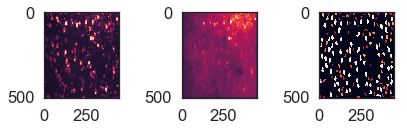

In [79]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(sitk.GetArrayFromImage(session.max_projection))
ax[1].imshow(sitk.GetArrayFromImage(session.average_projection))
ax[2].imshow(sitk.GetArrayFromImage(session.segmentation_mask_image))
plt.tight_layout()

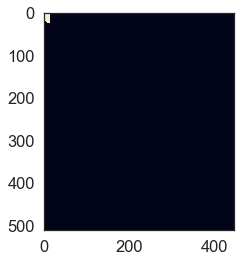

In [94]:
specimen_table=session.cell_specimen_table
roi_id=792865164

plt.imshow(specimen_table[specimen_table.cell_roi_id==roi_id].image_mask.values[0])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior timeseries and events - running, licks, rewards, and visual stimuli </h2>
<p>As the mouse performs the behavioral task, it is free to run on a disk. The task is a go/no-go style task with licking as the behavioral response. When a mouse correctly licks the water spout, a reward is delivered. 

<p>Running, licks and rewards are measured at the stimulus frame display rate and share timestamps with the stimulus. </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.1: Get running speed trace and timestamps** 

<p>Get the `running_speed` attribute of the dataset object. 

<p>Note that running speed is stored in a dataframe. What are the other columns of this dataframe? 

<p>Runnning speed shares timestamps with the visual stimulus. Compare the values of running timestamps from the `running_speed` dataframe with the values in the dataset attribute `timestamps_stimulus`. 
</div>

In [101]:
session.running_speed

RunningSpeed(timestamps=array([  13.63604,   13.6601 ,   13.67009, ..., 4516.16886, 4516.1886 ,
       4516.19923]), values=array([ 0.        ,  1.87921414,  1.42714319, ..., -0.12092068,
        0.        ,  0.        ]))

In [103]:
print('running speed timestamps:',session.running_speed.timestamps)

running speed timestamps: [  13.63604   13.6601    13.67009 ... 4516.16886 4516.1886  4516.19923]


In [104]:
print('stimulus timestamps:',session.stimulus_timestamps)

stimulus timestamps: <HDF5 dataset "timestamps": shape (269930,), type "<f8">


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.2: Plot running speed**

<p>1) Plot the values for running speed from the `running_speed` column of the dataframe. 

<p>2) Plot the x-axis in seconds, using `timestamps_stimulus` or using the `time` column of the `running_speed` dataframe. 

<p>Running speed is measured in cm/s. Label the axes appropriately.
</div>

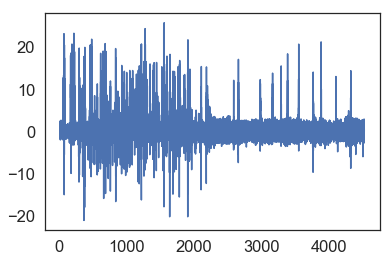

In [95]:
plt.plot(session.running_speed.timestamps, session.running_speed.values)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.3: Plot licking, reward times, and running trace on the same figure**
    
<p>1) Plot `running_speed` as above, but set xlims to focus on a 1 minute portion of the behavior session, from x=600 to x=660. 

<p>2) Plot `rewards` as points (not a line), at y = -10. Set marker='o' and linestyle='None'. Note that `rewards` is a dataframe. Use the values of the `time` column to get x-axis values to plot.

<p>Hint: You will need to create an array of len(dataset.rewards.time.values) filled with -10 to use as y-axis values to plot. np.repeat() is a convenient function for this.

<p>3) Plot `licking` times using plt.vlines() with ymin=-10 and ymax=-5. 

<p>4) Create a legend. Bonus: place the legend outside of the main figure.

<p>What is the relationship between running, licking and rewards? 
</div>

In [105]:
session.rewards.head()

,volume,autorewarded
timestamps,,
344.031673,0.007,False
361.261361,0.007,False
449.929279,0.007,False
469.398525,0.007,False
520.437516,0.007,False


In [106]:
session.licks.head()

,time
0,6.69973
1,6.84449
2,12.75827
3,12.91332
4,18.83490


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.4: Get the stimulus table**

<p>Get the `stimulus_table` attribute from the `dataset` object to identify the times of stimulus presentations. How many stimulus flashes were there? 
</div>

In [107]:
session.stimulus_presentations.head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,orientation,start_frame,start_time,stop_time
stimulus_presentations_id,,,,,,,,,,,
0,0.24970,18001.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,NaN,17986,313.65234,313.90204
1,0.24969,18046.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,NaN,18031,314.40248,314.65217
2,0.25006,18091.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,NaN,18076,315.15205,315.40211
3,0.24995,18136.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,NaN,18121,315.90203,316.15198
4,0.24994,18181.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,NaN,18166,316.65215,316.90209


In [ ]:
print('number of stimulus presentations =',len(dataset.stimulus_table))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.5: Plot visual stimulus presentations with behavior events**

<p>1) Copy and paste your code from Exercise 3.3, but now set xlims to zoom in on a 20 second window from t=600 to t=620. 

<p>2) Plot stimulus presentations using the `start_time` and `end_time` columns of the `stimulus_table` with plt.axvspan(). Set alpha=0.3 & facecolor='gray'.

<p>Hint: Loop through each row of the stimulus table to plot all stimulus flashes

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.6: Get visual stimulus template and metadata**

<p>Get `stimulus_metadata` and `stimulus_template` from the dataset object. How do they relate to each other? 

<p>The first dimension of `stimulus_template` corresponds to the `image_index` in `stimulus_metadata`.
</div>

In [ ]:
stimulus_metadata = dataset.stimulus_metadata
stimulus_metadata

In [ ]:
# session.stimulus_templates

In [ ]:
stimulus_template = dataset.stimulus_template
stimulus_template.shape

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.7: Plot a visual stimulus**

<p>1) Plot an image from the `stimulus_template` using plt.imshow. 

<p>2) Show the `image_name` in the title.

<p>Hint: Use `image_index` to translate between `stimulus_template` and `stimulus_metadata`.

</div>

In [ ]:
plt.imshow(session.stimulus_templates['Natural_Images_Lum_Matched_set_ophys_6_2017.07.14_2'][0, :, :])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior trials DataFrame</h2>
<p>The `trials` dataframe organizes behavior events (including licking and rewards), stimulus information (what stimulus was shown before and after the scheduled change time) and metadata (such as whether the trial was a 'go' trial or a 'catch' trial) for each behavioral trial. 

<p>This structure is convenient for data exploration and analysis.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.1: Explore the trial records**

<p>1) Get the `trials` attribute of the `dataset` object. What are the columns of this dataframe? What are the rows?

<p>How many trials were there? 

<p>How many of those trials had stimulus changes, aka 'go' trials? How many 'catch' trials?

<p>What images were shown in this behavior session? 
</div>

In [ ]:
trials = dataset.trials
trials.head()

In [ ]:
session.trials.head()

In [ ]:
#session.api.get_extended_trials()

In [ ]:
trials.keys()

In [ ]:
print('number of trials =',len(trials))

In [ ]:
print('number of go trials =',len(trials[trials.trial_type=='go']))

In [ ]:
print('number of catch trials =',len(trials[trials.trial_type=='catch']))

In [ ]:
images = trials.change_image_name.unique()
print(images)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 4.2: Get the behavioral response probability for go and catch trials**

<p>Response probability is the fraction of trials where the mouse emitted a lick during the response window. 

<p>The value of the `response` column is a boolean indicating whether or not the mouse emitted a lick on that trial.

<p>1) Select all the 'go' trials by filtering the dataframe by `trial_type`.

<p>2) Take the mean of the `response` column values for the selected trials to quantify the fraction of 'go' trials where the mouse emitted a behavioral response. 

<p>3) Repeat for 'catch' trials.

<p>***Add your values for response probability on go and catch trials to the plot on the board and draw a line between them***
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Bonus exercise 4.3: Plot response probability across images for go trials**

<p>1) Loop through the image names in `trials.change_image_name.unique()`

<p>2) Filter the `trials` dataframe by `change_image_name` and `trial_type` to get 'go' trials for each image.

<p>3) Quantify the fraction of 'go' trials with a `response` for each image. 

<p>3) Plot the mean response probability for each image. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.4: Plot a lick raster**

<p>Provide the `trials` dataframe to the function below to plot a lick raster.

<p>Is the mouse performing the task consistently across the whole session?
</div>

In [ ]:
def make_lick_raster(trials):
    fig,ax = plt.subplots(figsize=(5,10))
    for trial in trials.trial.values: 
        trial_data = trials.iloc[trial]
        # get times relative to change time
        trial_start = trial_data.start_time - trial_data.change_time
        lick_times = [(t - trial_data.change_time) for t in trial_data.lick_times]
        reward_time = [(t - trial_data.change_time) for t in trial_data.reward_times]
        # plot trials as colored rows
        ax.axhspan(trial, trial + 1, -200, 200, color=trial_data.trial_type_color, alpha=.5)
        # plot reward times
        if len(reward_time) > 0:
            ax.plot(reward_time[0], trial + 0.5, '.', color='b', label='reward', markersize=6)
        ax.vlines(trial_start, trial, trial + 1, color='black', linewidth=1)
        # plot lick times
        ax.vlines(lick_times, trial, trial + 1, color='k', linewidth=1)
        # annotate change time
        ax.vlines(0, trial, trial + 1, color=[.5, .5, .5], linewidth=1)
    # gray bar for response window
    ax.axvspan(trial_data.response_window[0], trial_data.response_window[1], facecolor='gray', alpha=.4,
               edgecolor='none')
    ax.grid(False)
    ax.set_ylim(0, len(trials))
    ax.set_xlim([-1, 4])
    ax.set_ylabel('trials')
    ax.set_xlabel('time (sec)')
    ax.set_title('lick raster')
    plt.gca().invert_yaxis()

In [ ]:
make_lick_raster(dataset.trials)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The ResponseAnalysis class organizes cell responses by behavior trials and stimulus flashes </h2>
<p>The `ResponseAnalysis` class takes a `VisualBehaviorDataset` object and extracts cell responses for the stimulus flashes in `stimulus_table` and for the trials in `trials`. 
<p>This does the work of temporal alignment for you, and translates between `timestamps_stimulus` and `timestamps_ophys` to get the times in the dF/F trace that correspond to stimulus presentations in `stimulus_table` and behavioral trial change times in `trials`.
<p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.1:** Generate the ResponseAnalysis object by passing in your dataset. 

<p>Generate the `ResponseAnalysis` object by passing in your `dataset`. Assign the object to a variable called `analysis`.

<p> What is available to you in the `ResponseAnalysis` class? Use help to check the documentation, or look directly at the code to see what operations are performed. 
</div>

In [ ]:
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

In [ ]:
analysis = ResponseAnalysis(dataset)

In [ ]:
help(ResponseAnalysis)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.2: Explore the flash response dataframe of the ResponseAnalysis object**

<p>What is in the `flash_response_df` attribute of the analysis object? What are the columns? What are the rows?  How is it different from the `stimulus_table` attribute of the dataset object?

<p>The`flash_response_df` contains the cell responses for individual stimulus presentations, aka flashes. It contains the `mean_response` of every cell in a 500ms window after every stimulus onset, for all stimulus presentations during the behavior session.  

<p>The `p_value` column is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms before the stimulus onset with the 500ms after the stimulus onset. 
</div>

In [ ]:
analysis.flash_response_df.head()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.3: Explore the trial response dataframe of the ResponseAnalysis object**

<p>1) Get the `trial_response_df` attribute of the analysis object. What are the columns? What are the rows? What is different than the `trials` records in the `dataset` object? What is different from the `flash_response_df`?

<p>The `trace` column contains a portion of each cell's dF/F trace for +/-4 seconds around the `change_time` for each trial. There are also `timestamps` for the same window of time. 

<p> For each trial, the `mean_response` of each cell is computed for a 500ms window after the `change_time`.

<p>The `p_value` is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms before the `change_time` (the baseline window) with the 500ms after the `change_time` (the response window). 

<p>2) Assign `trial_response_df` to a variable named `tdf` for convenient use in later exercises.
</div>

In [ ]:
analysis.trial_response_df.head(3)

In [ ]:
analysis.trial_response_df.keys()

In [ ]:
tdf = analysis.trial_response_df

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.4: Find the largest single trial response in the trial response dataframe**

<p>Each row of `trial_response_df` corresponds to a single trial for a single cell from the experiment. 

<p>1) Find the row of `tdf` that has the largest value of the `mean_response` column. Assign the trial number to a variable called `trial`.

<p>2) What cell had the largest response? Assign the cell index to the variable `cell`. You will use this cell throughout the rest of the notebook.

<p>3) What image evoked the largest response? Assign the image name to a variable called `change_image_name`

<p>4) Was it a 'go' or 'catch' trial? Assign the trial type to a variable called `trial_type`
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.5: Plot the largest single trial response in the trial_response_df**

<p>1) Plot the dF/F trace for the `trial` identified in the exercise above.

<p>Bonus: Plot the x_axis as time relative to the trial change time, using the `timestamps` column and knowledge of the range of the `trial_window` (+/- 4 seconds around the change time, accessed as an attribute of the `analysis` object)

<p>Extra bonus: Use the function `plot_single_trial_trace` from `visual_behavior.ophys.plotting.summary_figures` 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.6: Get the cell traces for all trials that meet the set of conditions that evoked the maximum single trial response**

<p>1) For your `cell`, get the dF/F traces in the `trace` column for all trials that meet the conditions that evoked the max response (combination of `trial_type` and `image_name` identified above) and assign to a variable called `traces`

<p>Hint 1: Use `cell`, `image_name`, and `trial_type` to index into `trial_response_df`

<p>Hint 2: Make sure to extract the an array of the values of response, not as a series
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.8: Plot the cell's' trial averaged trace for a set of conditions**

<p>1) Take the mean of the array of traces from exercise 5.5 and plot it. 

<p>What are the x and y axes? 

<p>Note the dynamics of the cell's response. What could be causing the changes in response magnitude over time? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.8: Plot the cell's' trial averaged response for go and catch trials using visual_behavior library plotting functions**

<p>1) For your cell, get the dF/F traces for all trials for the same `image_name` as above, for 'go' trials. 

<p>2) Use the function `plot_mean_trace` in visual_behavior.ophys.plotting.summary_figures to plot the mean trace. 

<p>Check the required inputs for this function using help or by entering shift+tab while the function is selected. You will need to use the `ophys_frame_rate` attribute of the `analysis` class.

<p>3) Use the function `plot_flashes_on_trace` to display stimulus presentation times. When is the cell active relative to stimulus display times? 

<p>Provide a string for the `trial_type` input of `plot_flashes_on_trace`. What is the effect of adding this input on the resulting figure?

<p>4) Repeat for 'catch' trials. How is the response different than on 'go' trials? 
</div>

In [ ]:
import visual_behavior.ophys.plotting.summary_figures as sf 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.9: Plot an image tuning curve for responses to the first flash after a change on 'go' trials**

<p>1) Filter `trial_response_df` to select only 'go' trials and assign to a variable called `df`.

<p>The `mean_response` column of the `trial_response_df` is the mean of the dF/F trace in a 500ms window after the change time for that trial.

<p>2) Loop through each `change_image_name` in `df.change_image_name.unique()` and get the values of the `mean_response` column for your `cell`.

<p>3) Take the average and SEM of the `mean_response` values for each `change_image_name` and plot a tuning curve. 

<p>Hint: use `from scipy.stats import sem` to get a function to compute the standard error. 

<p>How does the tuning curve compare with the one generated in exercise 5.9 using all stimulus presentations? Why would it be different?

<p>4) Save the averaged response to each image as an array called 'image_responses'.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Computing cell response metrics - lifetime sparseness </h2>
<p>'lifetime sparseness' is a metric for how selective and sparse a cell's activity is across conditions. A high value of this metric indicates high selectivity - a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions. 

<p>We will compute this metric for single cells and take the mean across the population. Before taking the mean, we will filter out cells that do not have a signficant image response.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.1: Compute lifetime sparseness using the mean image response on 'go' trials for your cell**
<p>Provide the array of `image_responses` created in Exercize 5.9 to the function below to compute the lifetime sparseness metric for your cell. 

<p>How selective is this cell? 
</div>

In [ ]:
def compute_lifetime_sparseness(image_responses):
    # image responses should be an array of the trial averaged responses to each image
    # sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
    # N = number of images
    # after Vinje & Gallant, 2000; Froudarakis et al., 2014
    N = float(len(image_responses))
    ls = ((1-(1/N) * ((np.power(image_responses.sum(axis=0),2)) / (np.power(image_responses,2).sum(axis=0)))) / (1-(1/N)))
    return ls

In [ ]:
ls = compute_lifetime_sparseness(image_responses)
print(ls)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.2: Identify cells with a significant image response**
<p>The `p_value` column of the `trial_response_df` is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms before the change time with the 500ms after the change time. This window is specified in the `response_window_duration` attribute of the `analysis` object. 

<p>Let's define responsive cells as having at least 10% of trials with a p_value < 0.005

<p>1) Loop through all cells, evaluate the fraction of trials with p_value < 0.005 and make a list of the indicies of responsive cells. Assign the list to a variable called `responsive_cells`.

<p>What fraction of cells in this experiment were responsive following a stimulus change? 

<p>***Add your value for fraction responsive cells to the plot on the board in the appropriate column based on your experiment's metadata***
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.3: Get the mean lifetime sparseness across  responsive cells** 

<p>1) Loop through each cell in `responsive_cells`, compute lifetime sparseness as you did above, and add the value to a list. 

<p>2) Convert the list to an array and take the mean.

<p>***Add your mean value to the plot on the board in the appropriate column based on your experiment's metadata***
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Bonus exercise 6.4: Compute lifetime sparseness for catch trials** 
    
<p>Repeat the exercise above using 'trial_response_df', filtered to include only 'catch' trials where no change in stimulus identity occured.

<p>How does the result compare to selectivity on 'go' trials only? Why would it be different? 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Project ideas </h2>
<p>Below is a list of suggested project ideas for working with the Visual Behavior dataset

</div>

* How do single cell or population response metrics vary between cre lines, areas or stimulus types? (ex: time-to-peak, reliability, fano factor, noise correlations, signal correlations, representational similarity, etc.)
* Are there distinct or continuous behavioral or neural states within a single behavioral session? (ex: task engagement, expectation, vigilance)
* How do response metrics vary across different states?
* Can different cell response profiles be classified using supervised or unsupervised clustering methods? 
* Do motor signals such as running and licking modulate neural respones in different cre lines or areas?
* Does reward expectation and trial history influence neural or behavioral responses? (ex: time since last reward, outcome of previous trial(s))
* Is there evidence of within session learning for untrained image sets? (behavior_session_B, C, D)
* How do cells respond when a stimulus flash is omitted? 
* Use dimensionality reduction or other methods to visualize the activity of many neurons at once. 